In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd

from csv import reader
import skimage
from skimage import io, transform, exposure, data, color
from skimage.color import *
import sys

import PIL
from PIL import Image

BBBC038 = "/raid/data/BBBC038/"
training_imgs_dir = "/raid/data/BBBC038/training/"

# View sample image

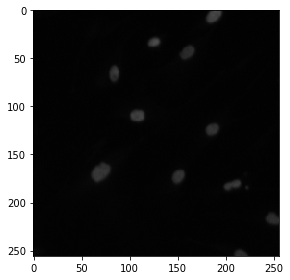

In [4]:
sample_dir = "/raid/data/BBBC038/training/ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0/"
os.listdir(sample_dir + 'images/')
io.imshow(sample_dir + 'images/ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0.png')

# Load All Data Into Lists

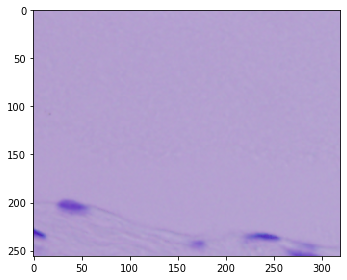

In [5]:
im_paths = []
mk_paths = []

for im_path in os.listdir(training_imgs_dir):
    path_masks = f"{training_imgs_dir}/{im_path}/masks/{im_path}"
    path_image = f"{training_imgs_dir}/{im_path}/images/{im_path}.png"

    mk_paths.append(path_masks)
    im_paths.append(path_image)

# sample
io.imshow(im_paths[100])


# Load All Labeled Data

In [93]:
image_groups = pd.read_csv(BBBC038 + "training_classifications.csv")
full_name = []

for i, image_name in image_groups.iterrows():
    full_name.append(image_name)
    
image_groups[image_groups["Type"] == "Purple"]
# full_name[2][1]
image_groups["Type"].unique()

array(['SuperBig', 'MaybeBIG', 'Pink-Purple', 'Default', 'TissueBW',
       'Purple'], dtype=object)

In [7]:
csv_lines = []
with open(BBBC038 + "training_classifications.csv") as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        csv_lines.append(row)

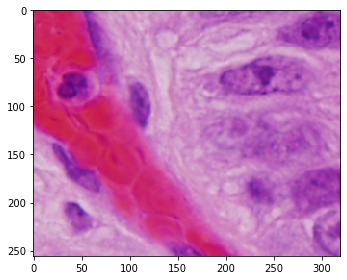

In [97]:
pink_png_list = []

for row in csv_lines:
    if "Pink-Purple" in row:
        pink_png_list.append(row[1])

io.imshow(training_imgs_dir + pink_png_list[0][:-4] + "/images/" + pink_png_list[0])

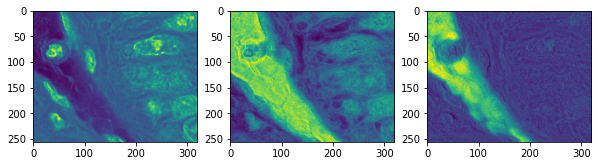

In [112]:
pink_img = io.imread(training_imgs_dir + pink_png_list[0][:-4] + "/images/" + pink_png_list[0])
pink_img = pink_img[:, :, [0, 1, 2]]

pink_hed = separate_stains(pink_img, hed_from_rgb)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
ax[0].imshow(pink_hed[:, :, 0])
ax[1].imshow(pink_hed[:, :, 1])
ax[2].imshow(pink_hed[:, :, 2])

4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06.png


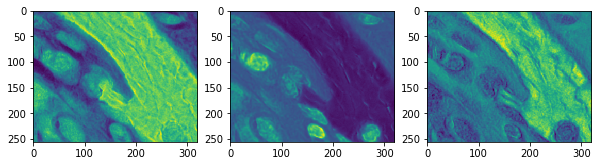

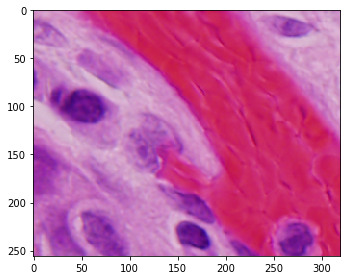

In [119]:
pink_img = io.imread(training_imgs_dir + pink_png_list[1][:-4] + "/images/" + pink_png_list[1])
print(pink_png_list[1])
pink_img = pink_img[:, :, [0, 1, 2]]

pink_rbd = separate_stains(pink_img, rbd_from_rgb)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
ax[0].imshow(pink_rbd[:, :, 0])
ax[1].imshow(pink_rbd[:, :, 1])
ax[2].imshow(pink_rbd[:, :, 2])
plt.figure()
io.imshow(pink_img)

# Find all Purple images and masks in directory

In [8]:
purple_png_list = []

for row in csv_lines:
    if "Purple" in row:
        purple_png_list.append(row[1])

# len(purple_png_list) # 104, as expected

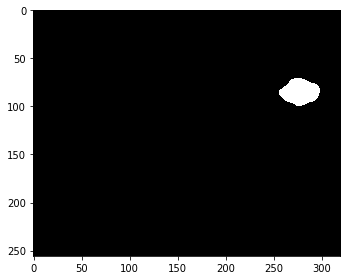

In [9]:
purp_collections = []
for i in range(104):
    curr_img_path = training_imgs_dir + purple_png_list[i][:-4] + "/masks/*.png"
    imcoll = io.collection.ImageCollection(curr_img_path)
    purp_collections.append(imcoll)
    
# first index is image collection, second is mask within collection
io.imshow(purp_collections[3][0])

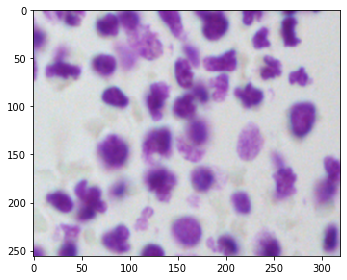

In [10]:
purp_sample_png_path = training_imgs_dir + purple_png_list[5][:-4] + "/images/" + purple_png_list[5]
purp_data = io.imread(purp_sample_png_path)
io.imshow(purp_data)

# Copy all images and masks in order to not damage dataset

In [11]:
purp_copies = []
copy_paths = []
mask_copies = []
copy_imgs_dir = "/raid/data/BBBC038/purp_imgs_copies/"
for i in range(104):
    curr_path = training_imgs_dir + purple_png_list[i][:-4]
    
    # get images, copy them and save them to copy directory
    purp_img = Image.open(curr_path + "/images/" + purple_png_list[i], 'r')
    copy = purp_img.copy()
    copy.save(copy_imgs_dir + purple_png_list[i])
    
    copy_paths.append(copy_imgs_dir + purple_png_list[i])
    purp_copies.append(copy)
    
    # get masks
    curr_masks_path = curr_path + "/masks/*.png"
    copy_coll = io.collection.ImageCollection(curr_img_path)
    
    mask_copies.append(copy_coll)

# Unmix Colors from Purple Images
* use separate stains
* use hamatoxylin and eosin (maybe ponceau fuchsin)
* see which stain(s) produce same output as cell profiler

Utilize PIL library to get pixel information

In [12]:
# Get the pixel from the given image
def get_pixel(image, i, j):
    # Inside image bounds?
    width, height = image.size
    if i > width or j > height:
      return None

    # Get Pixel
    pixel = image.getpixel((i, j))
    return pixel

In [13]:
# returns sorted list of occurrences a given RGBA color appears in an image
colors = purp_copies[5].getcolors(purp_copies[5].size[0] * purp_copies[5].size[1])
colors.sort()
# print(colors)

In [14]:
# returns minimum and maximum pixel value for each band
extrema = purp_copies[5].getextrema()
print(extrema)

((73, 234), (26, 230), (116, 246), (255, 255))


# Attempt at recreating Cell Profiler Unmix Colors
* Did not work; requires too many dependencies within cell profiler that are not easily translated 

In [126]:
CHOICE_HEMATOXYLIN = "Hematoxylin"
ST_HEMATOXYLIN = (0.644, 0.717, 0.267)

CHOICE_EOSIN = "Eosin"
ST_EOSIN = (0.093, 0.954, 0.283)

CHOICE_DAB = "DAB"
ST_DAB = (0.268, 0.570, 0.776)

CHOICE_FAST_RED = "Fast red"
ST_FAST_RED = (0.214, 0.851, 0.478)

CHOICE_FAST_BLUE = "Fast blue"
ST_FAST_BLUE = (0.749, 0.606, 0.267)

CHOICE_METHYL_BLUE = "Methyl blue"
ST_METHYL_BLUE = (0.799, 0.591, 0.105)

CHOICE_METHYL_GREEN = "Methyl green"
ST_METHYL_GREEN = (0.980, 0.144, 0.133)

CHOICE_AEC = "AEC"
ST_AEC = (0.274, 0.679, 0.680)

CHOICE_ANILINE_BLUE = "Aniline blue"
ST_ANILINE_BLUE = (0.853, 0.509, 0.113)

CHOICE_AZOCARMINE = "Azocarmine"
ST_AZOCARMINE = (0.071, 0.977, 0.198)

CHOICE_ALICAN_BLUE = "Alican blue"
ST_ALICAN_BLUE = (0.875, 0.458, 0.158)

CHOICE_PAS = "PAS"
ST_PAS = (0.175, 0.972, 0.155)

CHOICE_HEMATOXYLIN_AND_PAS = "Hematoxylin and PAS"
ST_HEMATOXYLIN_AND_PAS = (0.553, 0.754, 0.354)

CHOICE_FEULGEN = "Feulgen"
ST_FEULGEN = (0.464, 0.830, 0.308)

CHOICE_METHYLENE_BLUE = "Methylene blue"
ST_METHYLENE_BLUE = (0.553, 0.754, 0.354)

CHOICE_ORANGE_G = "Orange-G"
ST_ORANGE_G = (0.107, 0.368, 0.923)

CHOICE_PONCEAU_FUCHSIN = "Ponceau-fuchsin"
ST_PONCEAU_FUCHSIN = (0.100, 0.737, 0.668)

CHOICE_CUSTOM = "Custom"
STAIN_DICTIONARY = {
    CHOICE_AEC: ST_AEC,
    CHOICE_ALICAN_BLUE: ST_ALICAN_BLUE,
    CHOICE_ANILINE_BLUE: ST_ANILINE_BLUE,
    CHOICE_AZOCARMINE: ST_AZOCARMINE,
    CHOICE_DAB: ST_DAB,
    CHOICE_EOSIN: ST_EOSIN,
    CHOICE_FAST_BLUE: ST_FAST_BLUE,
    CHOICE_FAST_RED: ST_FAST_RED,
    CHOICE_FEULGEN: ST_FEULGEN,
    CHOICE_HEMATOXYLIN: ST_HEMATOXYLIN,
    CHOICE_HEMATOXYLIN_AND_PAS: ST_HEMATOXYLIN_AND_PAS,
    CHOICE_METHYL_BLUE: ST_METHYL_BLUE,
    CHOICE_METHYLENE_BLUE: ST_METHYLENE_BLUE,
    CHOICE_METHYL_GREEN: ST_METHYL_GREEN,
    CHOICE_ORANGE_G: ST_ORANGE_G,
    CHOICE_PAS: ST_PAS,
    CHOICE_PONCEAU_FUCHSIN: ST_PONCEAU_FUCHSIN,
}

(256, 320, 4)

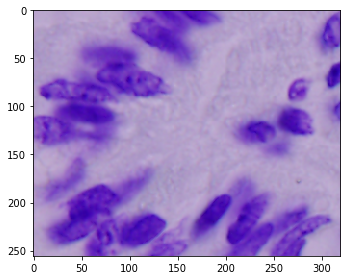

In [78]:
io.imshow(copy_paths[1])
read_img = io.imread(copy_paths[1])
read_img.shape

In [124]:
from skimage import data
from skimage.color import *

stain_img = read_img[:, :, [0, 1, 2]]
hematoxylin_matrix = np.ones((3,3)) * (0.644, 0.717, 0.267) # cell profiler matrix for purple images
hed_img = separate_stains(stain_img, matrix)
hed_img.shape

(256, 320, 3)

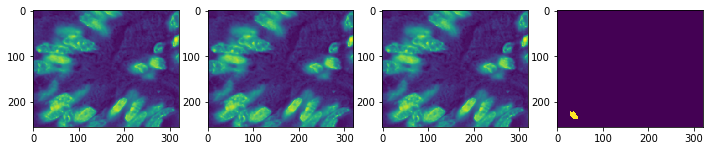

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 10))

# ax.set_title('fgx')
ax[0].imshow(hed_img[:, :, 0])
ax[1].imshow(hed_img[:, :, 1])
ax[2].imshow(hed_img[:, :, 2])
ax[3].imshow(mask_copies[1][0])

In [123]:
print(hed_from_rgb)

[[ 1.87798274 -1.00767869 -0.55611582]
 [-0.06590806  1.13473037 -0.1355218 ]
 [-0.60190736 -0.48041419  1.57358807]]
